# Infrared Spectroscopy Inverse Problem
---
*Jingtao Min @ ETH Zurich, 2023*

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from spectroscopy_inv import utils, absorbance_model

## Uniform sampling on a sphere

We need to generate uniformly distributed data on a sphere. I used [this website](http://corysimon.github.io/articles/uniformdistn-on-sphere/) for reference. The probability density and the marginals are

$$
p(\theta, \phi) = \frac{1}{4\pi}\sin\theta\quad \Longrightarrow \quad p(\theta) = \frac{1}{2}\sin\theta,\quad p(\phi) = \frac{1}{2\pi}
$$

For azimuth, uniform sampling is adequate; for colatitude, use [Inverse Transform Sampling](http://en.wikipedia.org/wiki/Inverse_transform_sampling):

$$
F(\theta) = \frac{1}{2}(1 - \cos\theta) = P(U<F(\theta)) = P(F^{-1}(U)<\theta)
$$

where $U\sim\mathcal{U}(0, 1)$. Therefore, a random variable with uniform distribution, when transformed using $F^{-1}$, satisfies the desired distribution described by cumulative distribution function $F$. For this sampling problem, the inverse is

$$
F^{-1}(U) = \arccos(1-2U)
$$

In [50]:
rng = np.random.default_rng(42)
rand_theta_dense = np.arccos(1 - 2*rng.random(size=600))
rand_phi_dense = 2*np.pi*rng.random(size=600)

N = 23
rand_theta_sparse = np.arccos(1 - 2*rng.random(size=N))
rand_phi_sparse = 2*np.pi*rng.random(size=N)

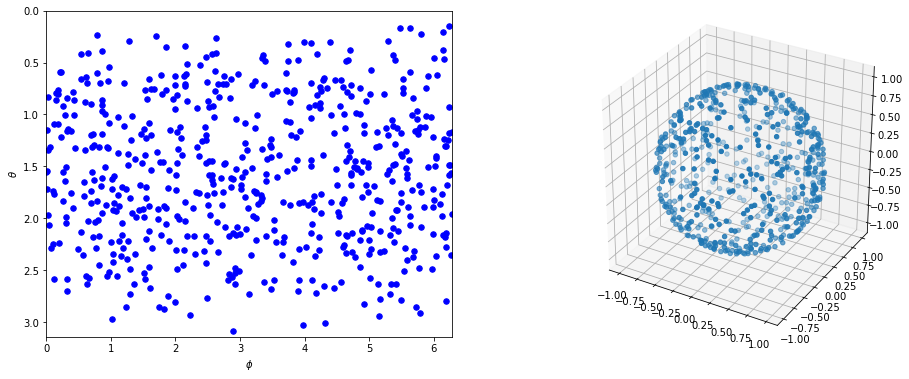

In [51]:
fig = plt.figure(figsize=(16, 6))
rand_phi, rand_theta = rand_phi_dense, rand_theta_dense

ax = fig.add_subplot(1, 2, 1)
ax.scatter(rand_phi, rand_theta, 30, 'b')
ax.invert_yaxis()
ax.set_xlim([0, 2*np.pi])
ax.set_ylim([np.pi, 0])
ax.set_xlabel(r"$\phi$")
ax.set_ylabel(r"$\theta$")

x_rand = np.sin(rand_theta)*np.cos(rand_phi)
y_rand = np.sin(rand_theta)*np.sin(rand_phi)
z_rand = np.cos(rand_theta)
ax = fig.add_subplot(1, 2, 2, projection="3d")
ax.scatter(x_rand, y_rand, z_rand, 'bo')
ax.set_box_aspect([1, 1, 1])

plt.show()

## Unpolarized infrared spectroscopy

### Synthetics

#### Synthetic model

In [52]:
A = np.array([1.89, 45.6, 80.94])
mod_absorb = absorbance_model.AbsorbanceModel(A, c_type="absorbance")
# A = np.array([2, 2, 80.94])
c = mod_absorb.coeffs
E_A, sigma_A = mod_absorb.moments()

print("Absorbance :", A)
print("Coefficient:", c)
print("E(A)       : %.2f" % E_A)
print("sigma(A)   : %.2f" % sigma_A)

Absorbance : [ 1.89 45.6  80.94]
Coefficient: [63.27  41.415 23.745]
E(A)       : 42.81
sigma(A)   : 10.22


#### Contours and visualizations

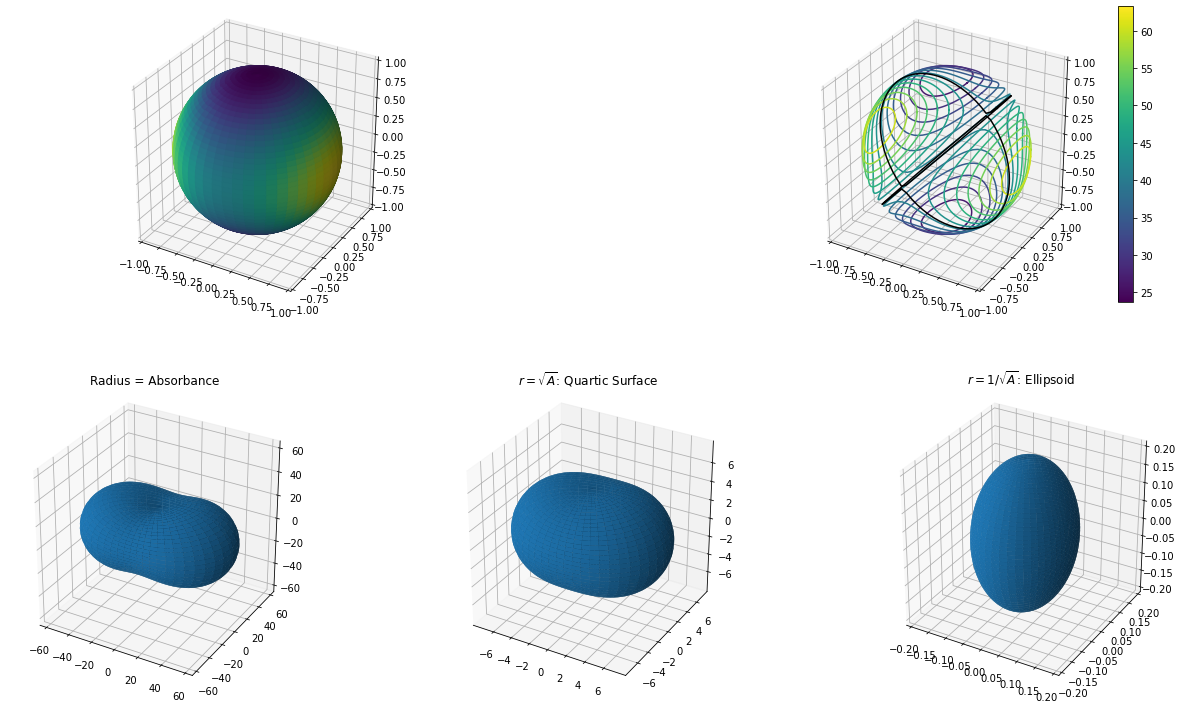

In [53]:
theta_mesh = np.linspace(0, np.pi, num=100)
phi_mesh = np.linspace(0, 2*np.pi, num=100)
Theta, Phi = np.meshgrid(theta_mesh, phi_mesh)
X, Y, Z = np.sin(Theta)*np.cos(Phi), np.sin(Theta)*np.sin(Phi), np.cos(Theta)
A_mesh = mod_absorb.eval_absorbance(X, Y, Z)

fig = plt.figure(figsize=(22, 12.5))

norm = mpl.colors.Normalize(vmin=A_mesh.min(), vmax=A_mesh.max())
ax = fig.add_subplot(2, 2, 1, projection="3d")
ax.plot_surface(X, Y, Z, facecolors=mpl.cm.viridis(norm(A_mesh)))
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_zlim([-1, 1])
ax.set_box_aspect([1, 1, 1])
# map_obj = plt.cm.ScalarMappable(cmap=mpl.cm.viridis, norm=norm)
# map_obj.set_array([])
# plt.colorbar(map_obj)

A_contours = np.linspace(c.min(), c.max(), num=15)
# A_contours = np.r_[A_contours, c[1]]
color_levels = plt.cm.viridis(norm(A_contours))
ax = fig.add_subplot(2, 2, 2, projection="3d")
for i_level, A_level in enumerate(A_contours):
    x_contour, y_contour, z_contour, closed_axis = mod_absorb.contour_absorbance(A_level)
    if closed_axis == 0:
        ax.plot(x_contour, y_contour, +z_contour, color=color_levels[i_level, :])
        ax.plot(x_contour, y_contour, -z_contour, color=color_levels[i_level, :])
    else:
        ax.plot(+x_contour, y_contour, z_contour, color=color_levels[i_level, :])
        ax.plot(-x_contour, y_contour, z_contour, color=color_levels[i_level, :])
x_crit, y_crit, z_crit, closed_axis = mod_absorb.contour_absorbance(c[1])
ax.plot(x_crit, y_crit, z_crit, color='k')
ax.plot(x_crit, y_crit, -z_crit, color='k')
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_zlim([-1, 1])
ax.set_box_aspect([1, 1, 1])
map_obj = plt.cm.ScalarMappable(cmap=mpl.cm.viridis, norm=norm)
map_obj.set_array([])
plt.colorbar(map_obj)

ax = fig.add_subplot(2, 3, 4, projection="3d")
ax.plot_surface(A_mesh*X, A_mesh*Y, A_mesh*Z)
rrange = A_mesh.max()
ax.set_xlim([-rrange, rrange])
ax.set_ylim([-rrange, rrange])
ax.set_zlim([-rrange, rrange])
ax.set_box_aspect([1, 1, 1])
ax.set_title(r"Radius = Absorbance")

ax = fig.add_subplot(2, 3, 5, projection="3d")
ax.plot_surface(np.sqrt(A_mesh)*X, np.sqrt(A_mesh)*Y, np.sqrt(A_mesh)*Z)
rrange = np.sqrt(A_mesh.max())
ax.set_xlim([-rrange, rrange])
ax.set_ylim([-rrange, rrange])
ax.set_zlim([-rrange, rrange])
ax.set_box_aspect([1, 1, 1])
ax.set_title(r"$r = \sqrt{A}$: Quartic Surface")

ax = fig.add_subplot(2, 3, 6, projection="3d")
ax.plot_surface(1/np.sqrt(A_mesh)*X, 1/np.sqrt(A_mesh)*Y, 1/np.sqrt(A_mesh)*Z)
rrange = 1/np.sqrt(A_mesh.min())
ax.set_xlim([-rrange, rrange])
ax.set_ylim([-rrange, rrange])
ax.set_zlim([-rrange, rrange])
ax.set_box_aspect([1, 1, 1])
ax.set_title(r"$r = 1/\sqrt{A}$: Ellipsoid")

plt.subplots_adjust(hspace=0.3)
plt.show()

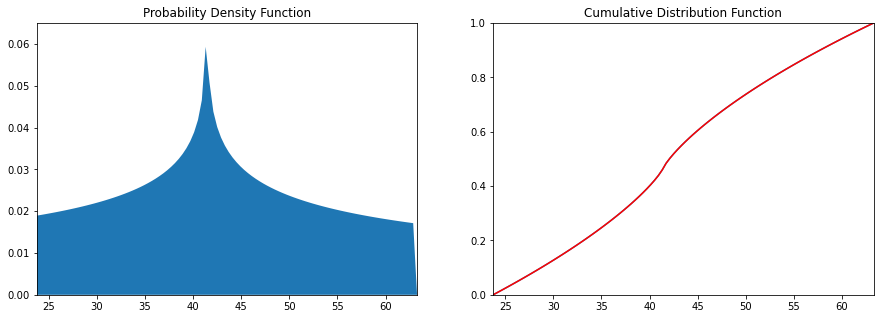

In [57]:
fig = plt.figure(figsize=(15, 5))
A_array = np.linspace(c[2], c[0], num=100)
pdf = mod_absorb.pdf(A_array)
cdf = mod_absorb.cdf(A_array)

ax = fig.add_subplot(1, 2, 1)
ax.fill_between(A_array, pdf)
ax.autoscale(enable=True, axis='x', tight=True)
ax.set_ylim([0, 0.065])
ax.set_title("Probability Density Function")

ax = fig.add_subplot(1, 2, 2)
ax.plot(A_array, cdf)
cdf_v2 = [likelihood.cdf(Q, *mod_absorb.coeffs) for Q in A_array]
ax.plot(A_array, cdf_v2, 'r')
ax.autoscale(enable=True, axis='x', tight=True)
ax.set_ylim([0, 1])
ax.set_title("Cumulative Distribution Function")

plt.show()

#### Synthetic samples and estimation

In [70]:
rand_phi, rand_theta = rand_phi_dense, rand_theta_dense
A_obs = mod_absorb.eval_absorbance(np.ones(rand_phi.shape), rand_theta, rand_phi, x_type="spherical")
A_min, A_max, A_mean = np.min(A_obs), np.max(A_obs), np.mean(A_obs)
A_stdev = np.sqrt(np.mean(A_obs**2) - A_mean**2)
c_est = np.array([A_max, 3*A_mean - A_max - A_min, A_min])
A_est = utils.coeffs_to_absorbance(c_est)

print("Obs -----------------------")
print("Mean       : %.2f" % A_mean)
print("Sigma      : %.2f" % A_stdev)
print("Est. Coeffs:", c_est)
print("Est. Absorb:", A_est)

Obs -----------------------
Mean       : 42.98
Sigma      : 10.25
Est. Coeffs: [63.26290605 41.78964551 23.88183628]
Est. Absorb: [ 2.40857574 45.35509682 81.17071528]


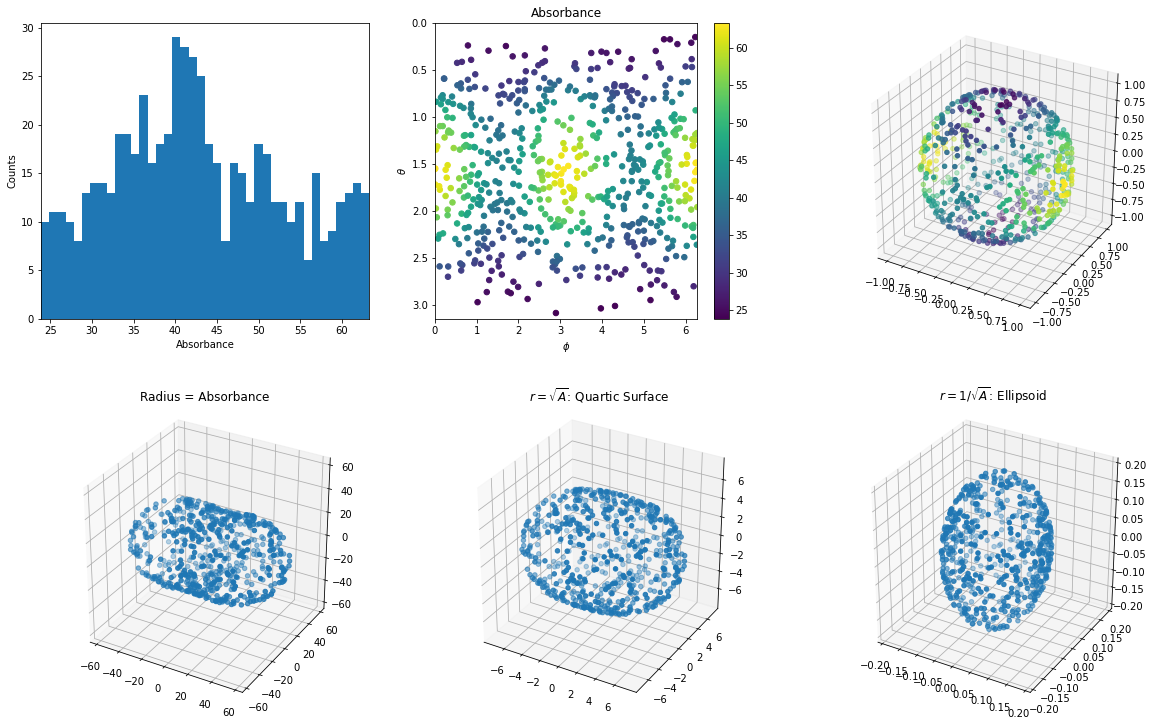

In [71]:
fig = plt.figure(figsize=(20, 12.5))

ax = fig.add_subplot(2, 3, 1)
ax.hist(A_obs, bins=40)
ax.set_xlabel("Absorbance")
ax.set_ylabel("Counts")
ax.autoscale(enable=True, axis='x', tight=True)

ax = fig.add_subplot(2, 3, 2)
cm = ax.scatter(rand_phi, rand_theta, s=30, c=A_obs)
plt.colorbar(cm)
ax.invert_yaxis()
ax.set_xlim([0, 2*np.pi])
ax.set_ylim([np.pi, 0])
ax.set_xlabel(r"$\phi$")
ax.set_ylabel(r"$\theta$")
ax.set_title("Absorbance")

ax = fig.add_subplot(2, 3, 3, projection="3d")
ax.scatter(x_rand, y_rand, z_rand, c=A_obs)
ax.set_box_aspect([1, 1, 1])

x_obs = A_obs*np.sin(rand_theta)*np.cos(rand_phi)
y_obs = A_obs*np.sin(rand_theta)*np.sin(rand_phi)
z_obs = A_obs*np.cos(rand_theta)
ax = fig.add_subplot(2, 3, 4, projection="3d")
ax.scatter(x_obs, y_obs, z_obs, 'bo')
ax.set_xlim([-A_max, A_max])
ax.set_ylim([-A_max, A_max])
ax.set_zlim([-A_max, A_max])
ax.set_box_aspect([1, 1, 1])
ax.set_title("Radius = Absorbance")

x_obs = np.sqrt(A_obs)*np.sin(rand_theta)*np.cos(rand_phi)
y_obs = np.sqrt(A_obs)*np.sin(rand_theta)*np.sin(rand_phi)
z_obs = np.sqrt(A_obs)*np.cos(rand_theta)
ax = fig.add_subplot(2, 3, 5, projection="3d")
ax.scatter(x_obs, y_obs, z_obs, 'bo')
ax.set_xlim([-np.sqrt(A_max), +np.sqrt(A_max)])
ax.set_ylim([-np.sqrt(A_max), +np.sqrt(A_max)])
ax.set_zlim([-np.sqrt(A_max), +np.sqrt(A_max)])
ax.set_box_aspect([1, 1, 1])
ax.set_title(r"$r = \sqrt{A}$: Quartic Surface")

x_obs = 1/np.sqrt(A_obs)*np.sin(rand_theta)*np.cos(rand_phi)
y_obs = 1/np.sqrt(A_obs)*np.sin(rand_theta)*np.sin(rand_phi)
z_obs = 1/np.sqrt(A_obs)*np.cos(rand_theta)
ax = fig.add_subplot(2, 3, 6, projection="3d")
ax.scatter(x_obs, y_obs, z_obs, 'bo')
ax.set_xlim([-1/np.sqrt(A_min), +1/np.sqrt(A_min)])
ax.set_ylim([-1/np.sqrt(A_min), +1/np.sqrt(A_min)])
ax.set_zlim([-1/np.sqrt(A_min), +1/np.sqrt(A_min)])
ax.set_box_aspect([1, 1, 1])
ax.set_title(r"$r = 1/\sqrt{A}$: Ellipsoid")

plt.subplots_adjust(hspace=0.3)
plt.show()

#### Probability density function

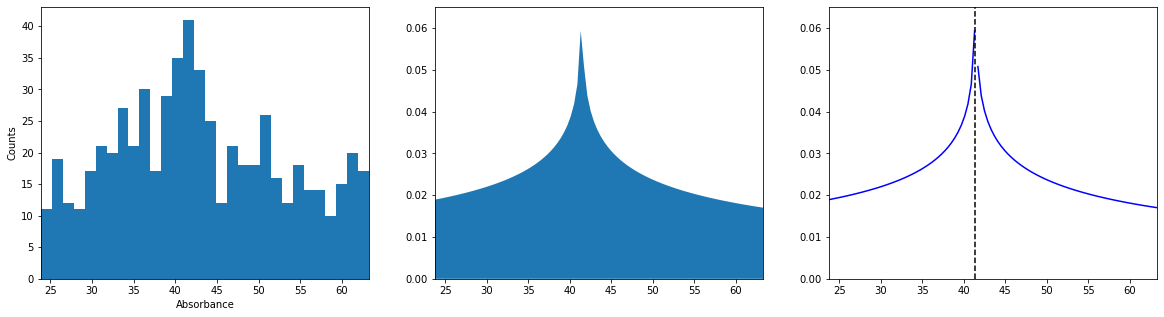

In [72]:
A_array = np.linspace(c[0], c[2], num=100)
pdf = mod_absorb.pdf(A_array)

fig = plt.figure(figsize=(20, 5))

ax = fig.add_subplot(1, 3, 1)
ax.hist(A_obs, bins=30)
ax.autoscale(enable=True, axis='x', tight=True)
ax.set_xlabel("Absorbance")
ax.set_ylabel("Counts")

ax = fig.add_subplot(1, 3, 2)
ax.fill_between(A_array, pdf)
ax.autoscale(enable=True, axis='x', tight=True)
ax.set_ylim([0, 0.065])

ax = fig.add_subplot(1, 3, 3)
idx = A_array < c[1]
ax.plot(A_array[idx], pdf[idx], 'b-')
idx = A_array > c[1]
ax.plot(A_array[idx], pdf[idx], 'b-')
ax.vlines([c[1],], ymin=0, ymax=0.07, colors=['k'], linestyles="dashed")
ax.autoscale(enable=True, axis='x', tight=True)
ax.set_ylim([0, 0.065])

plt.show()

## Likelihood distribution

In [40]:
data_all = np.array([44.15967, 49.92802, 43.72898, 34.96102, 37.11223, 48.20369, 44.02242, 32.64254, 
                     39.17191, 39.30958, 41.48838, 60.79360, 27.77383, 62.43976, 42.75821, 30.67905, 
                     61.95585, 25.06300, 33.80495, 42.13757, 36.95285, 29.79391, 26.66335])

a1_arr, a2_arr, a3_arr, llk = absorbance_model.grid_llk(data_all, 0.1, (100, 100, 100))


Performing grid search on grid 100 x 100 x 100 
Discretization intervals delta a1 = 1.14810772 delta a2 = 0.4612703600000001 delta a3 = 0.6868373600000001 
with 140674 feasible points...

--- 63.0107 seconds compute time ---


In [41]:
import h5py

with h5py.File("./llk_test20_0.1.h5", 'x') as f:
    f.create_dataset("coordinates", data=np.stack([a1_arr, a2_arr, a3_arr], axis=0))
    f.create_dataset("log_likelihood", data=llk)

### Visualization

In [42]:
import h5py

with h5py.File("./llk_test20_0.1.h5", 'r') as f:
    coordinates = f["coordinates"][()]
    llk = f["log_likelihood"][()]

a1_arr, a2_arr, a3_arr = coordinates[0, :], coordinates[1, :], coordinates[2, :]

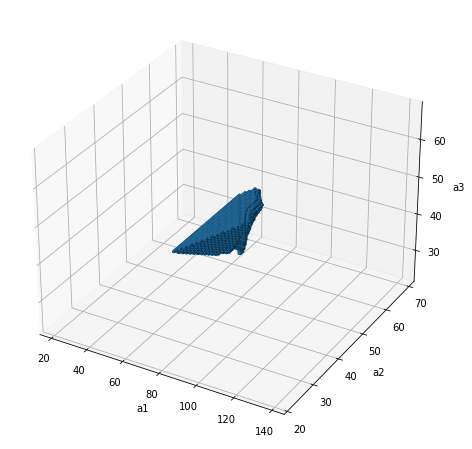

In [5]:
da1, da2, da3 = a1_arr[1] - a1_arr[0], a2_arr[1] - a2_arr[0], a3_arr[1] - a3_arr[0]
a1_node, a2_node, a3_node = np.r_[a1_arr - da1/2, a1_arr[-1] + da1/2], np.r_[a2_arr - da2/2, a2_arr[-1] + da2/2], np.r_[a2_arr - da2/2, a2_arr[-1] + da2/2]
a1_node_mesh, a2_node_mesh, a3_node_mesh = np.meshgrid(a1_node, a2_node, a3_node, indexing='ij')

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1, projection="3d")

# ax.view_init(elev=10, azim=225)

ax.voxels(a1_node_mesh, a2_node_mesh, a3_node_mesh, llk > -95)
ax.set_xlabel('a1')
ax.set_ylabel('a2')
ax.set_zlabel('a3')

plt.show()

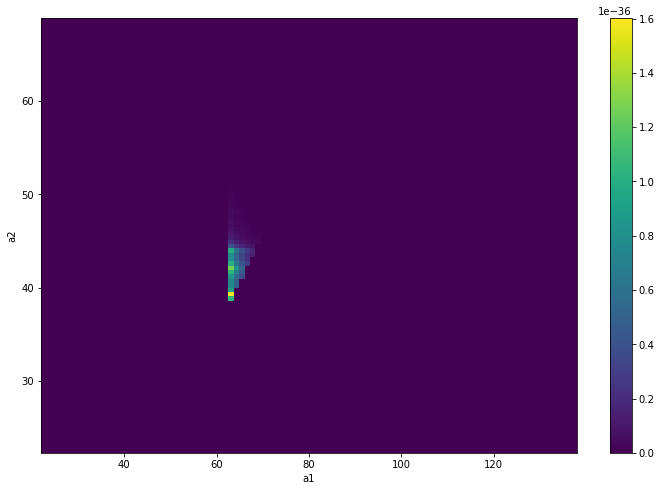

In [47]:
plt.figure(figsize=(12, 8))
plt.pcolormesh(a1_node_mesh[:, :, 35], a2_node_mesh[:, :, 35], np.exp(llk[:, :, 35]))
plt.xlabel("a1")
plt.ylabel("a2")
plt.colorbar()
# plt.gca().axis('equal')
plt.show()

## Test codes

### Efficiency of evaluating elliptic integrals
Try two approaches:
- SymPy `elliptic_pi` method
- Customized code using SciPy `special` module

In [97]:
import sympy.functions.special.elliptic_integrals as ellip
import time

In [100]:
test_n = np.linspace(0, 0.8, num=100)
test_k = np.linspace(0, 0.8, num=100)
n_array, k_array = np.meshgrid(test_n, test_k)
n_array = n_array.flatten()
k_array = k_array.flatten()

t_start = time.time()
o_list_sympy = [float(ellip.elliptic_pi(n_array[i], k_array[i]).evalf()) for i in range(n_array.size)]
t_end = time.time()
print("SymPy eval: {:.2f}".format(t_end - t_start))

t_start = time.time()
o_list_scipy = prob.ellipp(n_array, k_array)
t_end = time.time()
print("SciPy eval: {:.2f}".format(t_end - t_start))

SymPy eval: 36.21
SciPy eval: 0.00


In [104]:
for i in range(20):
    print("{:.15f}, {:.15f}".format(o_list_sympy[i], o_list_scipy[i]))

1.570796326794897, 1.570796326794897
1.577181704042309, 1.577181704042309
1.583645590572476, 1.583645590572476
1.590189608494011, 1.590189608494011
1.596815427227632, 1.596815427227633
1.603524765295312, 1.603524765295312
1.610319392192805, 1.610319392192805
1.617201130350215, 1.617201130350215
1.624171857185517, 1.624171857185517
1.631233507256291, 1.631233507256291
1.638388074515273, 1.638388074515273
1.645637614675690, 1.645637614675690
1.652984247692753, 1.652984247692753
1.660430160368109, 1.660430160368109
1.667977609084519, 1.667977609084519
1.675628922678527, 1.675628922678527
1.683386505459425, 1.683386505459425
1.691252840383406, 1.691252840383406
1.699230492392407, 1.699230492392407
1.707322111927865, 1.707322111927865


In [27]:
import numpy as np
import scipy
from scipy import sparse
from scipy.sparse.linalg import eigsh, eigs
from scipy.linalg import eig

In [33]:
a = np.diag(np.random.randn(3)).astype(np.longdouble)
A = sparse.csc_array(a)

In [34]:
A

<3x3 sparse array of type '<class 'numpy.float64'>'
	with 3 stored elements in Compressed Sparse Column format>

In [17]:
eig(A - np.eye(3))

(array([ 0.41971898+0.j, -1.0674309 +0.j,  0.72462185+0.j]),
 array([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]]))